In [146]:
from MVN import MultivariateNormal
# Class which includes all things MVN, including univariate Gaussians.
# Also provides Cholesky sampling.

from MCMC import MetropolisHastings, Gibbs, Cholesky, SampleSet2D
# The classes MetropolisHastings, Gibbs, Cholesky inherit from 
# MCMC.Sampler, a generic container for a (possibly MonteCarlo)
# sampler for a distribution. An instance of each of these corresponds
# to one "chain".

# The "Cholesky" class is provided in order to make comparisons easier,
# but its functionality is already included in the MultivariateNormal class.

# The class SampleSet2D contains methods for plotting and analyzing
# a 2D distribution starting from samples calculated using one of the 
# aforementioned methods.

from multiple_chains import MultipleChains, errors_sampler, plot_errors
# The MultipleChains class is made to include several chains of a single type,
# and to extend them in parallel; further, it allows for the computation of
# parameters (mean, covariance) starting from the combined chains, 
# as well as being able to generate trace plots and other quality checks.

# The errors_sampler and plot_errors functions can be used together,
# in order to gauge the accuracy of the 

from tqdm import tqdm
# For pretty progress bars.

In [147]:
# the given parameters of the MVN we want to explore are these:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

# we shall draw credible intervals at
CL = .95

# we create an instance of the MultivariateNormal class, this 
# will allow us to make all of the necessary calculations
# and will be used as an argument for the MonteCarlo samplers as well,
# since it has a convenient pdf method 
n = MultivariateNormal(mean, covariance)

print(f'n is a {n}')

n is a 2-dimensional MVN with mean [4 2] and covariance [[ 1.44  -0.702]
 [-0.702  0.81 ]]


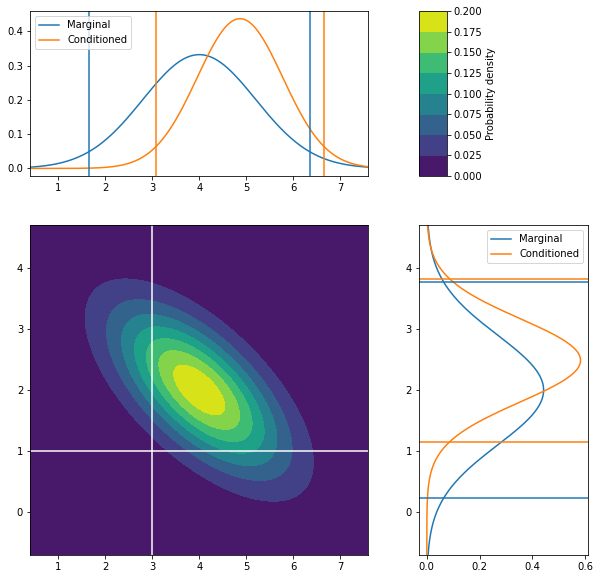

In [148]:
# we make a bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# as well as credible intervals for each univariate Gaussian 
n.plot_2d_analytical(chosen_x=3, chosen_y=1, CL=CL)

In [149]:
# we can also print out the margins of the intervals

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)

chosen_x = 3
chosen_y = 1
cx = n.condition(0, chosen_y)
CI_x_analytical_conditioned = cx.analytical_CI(CL)
cy = n.condition(1, chosen_x)
CI_y_analytical_conditioned = cy.analytical_CI(CL)

print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

print(f'The Credible Interval for x, fixing y to be equal to {chosen_y}, is between {CI_x_analytical_conditioned[0]:.2f} and {CI_x_analytical_conditioned[1]:.2f}')
print(f'The Credible Interval for y, fixing x to be equal to {chosen_x}, is between {CI_y_analytical_conditioned[0]:.2f} and {CI_y_analytical_conditioned[1]:.2f}')

The Credible Interval for x is between 1.65 and 6.35
The Credible Interval for y is between 0.24 and 3.76
The Credible Interval for x, fixing y to be equal to 1, is between 3.08 and 6.65
The Credible Interval for y, fixing x to be equal to 3, is between 1.15 and 3.83


In [150]:
## CHOLESKY SAMPLING

# This way of sampling is only appicable to Gaussians.
# The idea is to take the "matrix square root" of the covariance:
# We calculate a lower-triangular matrix L such that 
# L @ L.T = n.cov

# This is accomplished with the aid of the function numpy.linalg.cholesky:
# we find 
L = n.cholesky_L

print('The matrix L is:')
print(L)
print('\nIndeed, the equation is satisfied: L @ L.T - n.cov =')
print(L @ L.T - n.cov)

The matrix L is:
[[ 1.2         0.        ]
 [-0.585       0.68394079]]

Indeed, the equation is satisfied: L @ L.T - n.cov =
[[0. 0.]
 [0. 0.]]


In [151]:
%%markdown

Having found a matrix with this property, it is easy to generate Gaussian 
samples distributed according to the covariance matrix $C$ (`n.cov`):
we start by generating zero-mean, unit-covariance Gaussian samples $x_i$, such that $\langle x_i x_j \rangle = \mathbb{I}_{ij}$ .

Then, we multiply them by $L$ to get $y_i = L_{ij} x_j$, and we are almost done, since their covariance will be now given by

$$
\langle y_i y_k \rangle
= \langle L_{ij} x_j L_{kl} x_l \rangle 
= \langle L_{ij} x_j x_l L_{lk}^T \rangle
= L_{ij} \langle  x_j x_l  \rangle L_{lk}^T 
= L_{ij} \mathbb{I}_{jl} L_{lk}^T = C_{ik}
\,.
$$

Therefore, we now have zero-mean Gaussian samples with the correct covariance: we only need to shift them to get the desired mean, and we are done.


Having found a matrix with this property, it is easy to generate Gaussian 
samples distributed according to the covariance matrix $C$ (`n.cov`):
we start by generating zero-mean, unit-covariance Gaussian samples $x_i$, such that $\langle x_i x_j \rangle = \mathbb{I}_{ij}$ .

Then, we multiply them by $L$ to get $y_i = L_{ij} x_j$, and we are almost done, since their covariance will be now given by

$$
\langle y_i y_k \rangle
= \langle L_{ij} x_j L_{kl} x_l \rangle 
= \langle L_{ij} x_j x_l L_{lk}^T \rangle
= L_{ij} \langle  x_j x_l  \rangle L_{lk}^T 
= L_{ij} \mathbb{I}_{jl} L_{lk}^T = C_{ik}
\,.
$$

Therefore, we now have zero-mean Gaussian samples with the correct covariance: we only need to shift them to get the desired mean, and we are done.


Credible Intervals: (xmin, xmax), then (ymin, ymax)
[[1.63 6.34]
 [0.25 3.76]]


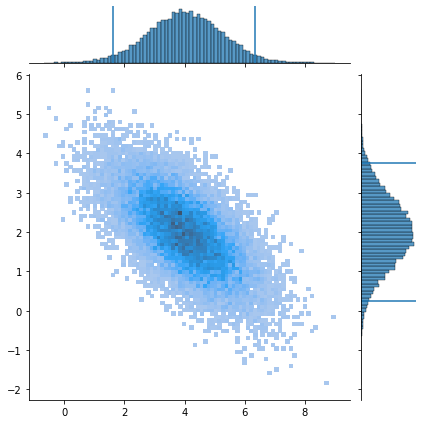

In [152]:
# This procedure is implemented in the cholesky_sample method of the MultivariateNormal class.
# Here we show a histogram of the resulting samples.

# The histogram is generated with the aid of the seaborn library, 
# with the addition of the marginal distributions' 
# credible intervals computed numerically from the samples.

samples_ch = SampleSet2D(n.cholesky_sample(20000))
samples_ch.samples_plot(CL, kind='hist')
print('Credible Intervals: (xmin, xmax), then (ymin, ymax)')
with np.printoptions(precision=2):
    print(np.array(samples_ch.intervals(CL)))

In [153]:
## METROPOLIS - HASTINGS SAMPLING

# This kind of sampling is implemented by the class MetropolisHastings.
# We need to provide it with a proposal distribution; we choose a Gaussian
# centered on the previous point, with the identity matrix as a covariance matrix.


from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

# We directly start several chains, they will be updated in parallel.
# A good choice is the number of CPUs on one's computer minus one.

num_chains = 7

# We need to provide an initial position for each chain. 
# To simulate our ignorance of the true location of the peak of the distribution, we take
# these to be distributed with a large spread compared to the true scale of the distribution.
spread_initial_positions = 10
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

# We will let each chain run for only a few steps, in order to figure out where to trim their beginnings. 
chain_length = 500

# The MultipleChains class will do all the work of computing these chains: 
mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

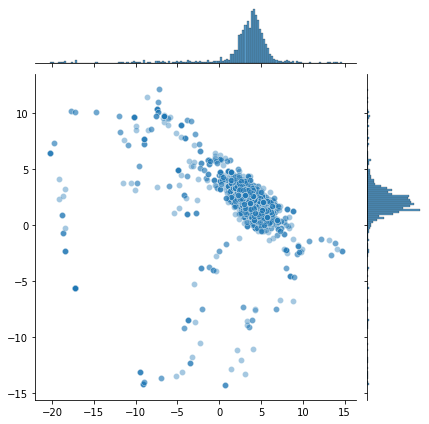

In [154]:
# Let us first show a scatterplot of the chains converging to the true region of the maximum.

samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(kind='scatter', alpha=.4)

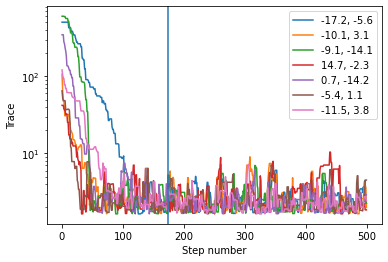

In [155]:
# Now, the start of each of these chains should be thrown out, since many of them were sampling in 
# extremely unlikely regions. 
# This is clearly shown by the trace plots, which show the variation of the log-posterior
# computed at the points touched by the chains.

# The legend shows the starting points of the various chains.

# A heuristic is implemented in the method "optimal_trimming" to give a 
# step number starting from which we are reasonably confident that the chains are
# indeed sampling from the true distribution. 
# This is shown as a vertical line in the plot. 

mh.traces_plot(every=1)
plt.axvline(mh.optimal_trimming)
plt.yscale('log')

In [156]:
# Now that we know where to do so, we can trim the beginning of each chain.
# For simplicity (and to be sure) we trim them all at the maximum point, since
# we do not lose much by doing so.

# The trim function is well-behaved, so re-running this cell multiple times should not give any issues.

mh.trim_chains(mh.optimal_trimming)

# Then, we extend the chains by a large-ish number of steps, in order to get good statistics. 
mh.extend_chains(int(2e4))

# Now, the average acceptance rates look like this:
print('Acceptance rates: ')
for s in mh.samplers:
    print(f'{s.acceptance_rate*100:.1f}%', end=', ')

Trimming at 174
Acceptance rates: 
47.5%, 48.7%, 48.1%, 48.6%, 48.7%, 47.9%, 48.3%, 

In [157]:
# We implement the Gelman-Rubin test, finding a matrix R
# whose components should all be only slightly above 1.
# This is indeed the case, so we can keep believing that we have found convergence.

print(f'R - 1 =  {mh.R_estimator() - 1}\n')

R - 1 =  [[0.00109715 0.00131963]
 [0.00131963 0.00087768]]



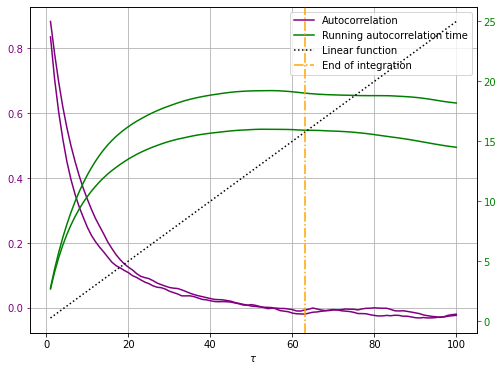

In [158]:
# Next, we compute the autocorrelation times for the various chains.
# Let us show how the computation goes for the first, the others are analogous.

# The autocorrelation time can be estimated from the autocorrelation of the two parameters,
# which can be computed at a variable time delay.
# In principle, in order to compute the autocorrelation time we should sum over all possible 
# delays, however the autocorrelation quickly becomes noise-dominated.

# Thus, we want to only sum over the region near zero, which contains the signal.
# In order to achieve this, we consider the cumulative sum, which tapers off
# after the region which we want to sum over, and we compare it to a low-slope linear function. 
# We then consider the cumulative sum at the first crossover time.

# get the autocorrelations at variable delays, from 1 to 100:
t, a = mh.samplers[0].autocorrelation_array(100)

fig, ax = plt.subplots(figsize=(8,6))

mh.samplers[0].autocorrelation_plot(100, ax=ax, c='purple')
times = 1 + 2 * np.cumsum(a, axis=0)
ax.tick_params(axis='y', colors='purple')
ax.grid('on')

# duplicate y axis, in order to show both the autocorrelation and 
# its cumulative sum on the same axis
ax2 = ax.twinx()

linear = np.array(t) / 4
end_integration = min(np.argmax(linear[:, np.newaxis] > times, axis=0))

ax2.plot(t, times, c='green', label='Running autocorrelation time')
ax2.plot(list(t), linear, ls=':', label='Linear function', c='black')
ax2.tick_params(axis='y', colors='green')
ax2.axvline(end_integration, ls='-.', c='orange', label='End of integration')

handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels+labels2, handles+handles2))
ax.legend(by_label.values(), by_label.keys())

In [159]:
# The autocorrelation time is then computed as the average of the autocorrelation times for the two parameters.
# Here are the results for the various chains which were run:

for t in (ac_times := mh.autocorrelation_times()):
    print(f'{t:.1f}', end=', ')

print(f'average autocorrelation time = {np.average(ac_times):.3f}')

17.4, 20.2, 16.2, 15.3, 19.6, 14.8, 16.1, average autocorrelation time = 17.066


Credible Intervals: (xmin, xmax), then (ymin, ymax)
[[1.67 6.39]
 [0.22 3.73]]


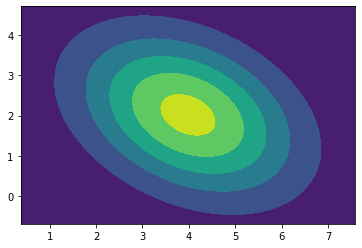

In [160]:
# We can also generate a Kernel Density Estimate plot of the samples;
# this can be performed quickly thanks to the KDEpy library,
# which moves to Fourier space in order to get a large speedup.

# The result visually matches the true distribution.

samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot_kde()

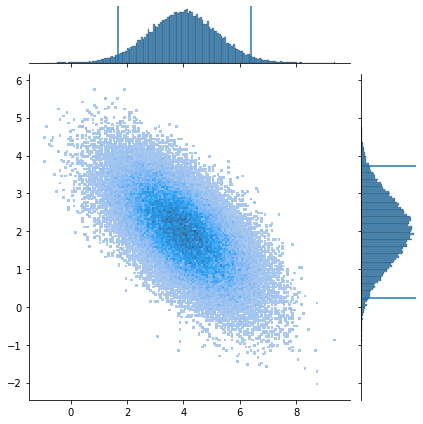

In [184]:
# We also show a histogram for the same data,
# with the marginal histograms plotted together with the boundaries
# of the Credible Intervals

samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL=CL, kind='hist')

In [161]:
# Finally, let us check that the mean and covariance match 
# those of the given distribution:

print(f'{mean} vs {SS_mh.mean}: the average error is {100 * np.sqrt(np.average((mean-SS_mh.mean)**2)):.1f}% for the mean\n')
print(f'{covariance} (original)\n vs\n {SS_mh.covariance} (estimated)\n The average error is {100 * np.sqrt(np.average((covariance-SS_mh.covariance)**2)):.1f}% for the covariance')

[4 2] vs [4.01630827 1.99465459]: the average error is 1.2% for the mean

[[ 1.44  -0.702]
 [-0.702  0.81 ]] (original)
 vs
 [[ 1.49733557 -0.73925016]
 [-0.73925016  0.83856883]] (estimated)
 The average error is 4.1% for the covariance


In [172]:
## GIBBS SAMPLING

# This algorithm allows us to sample from a distribution, as long as we know 
# its conditional distriibution at each point.
# In the case of the Gaussian, we can compute it analytically. 

# The methods needed for the conditioning are already included in the
# MultivariateNormal class, so we only need to calculate a random deviate
# and turn it into a deviate from the desired univariate Gaussian conditional distribution.

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

# as before, we start with short chains in order to see what the trace looks like

chain_length = 100
g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)


Trimming at 4


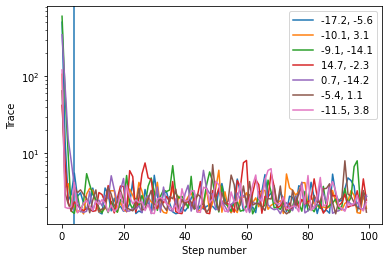

In [173]:
# The chain converges much faster than Metropolis-Hastings to the true distribution,
# since we can move like the tower in chess: once we are on the same horizontal or
# vertical position as the bulk of the distribution, we can reach it in one move.

plt.axvline(g.optimal_trimming)
g.traces_plot(every=1)

g.trim_chains(g.optimal_trimming)
plt.yscale('log')

In [164]:
# like in the other case, we extend the chain in order to get better statistics

g.extend_chains(int(1e4))

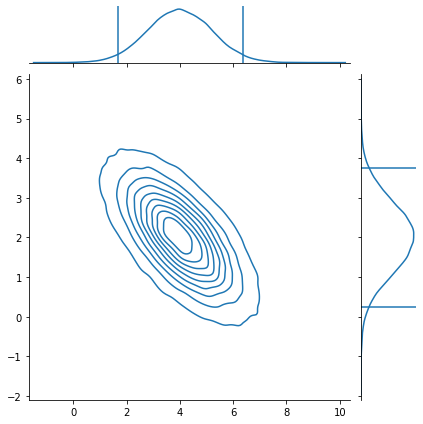

In [165]:
# This time, we make a KDE plot of the full distribution with the aid 
# of the inbuilt functions from the seaborn module.

samples_gibbs = SampleSet2D(g.all_chains)

samples_gibbs.samples_plot(CL, kind='kde')

Text(0, 0.5, '$\\mathbb{P}(x | y = 1)$')

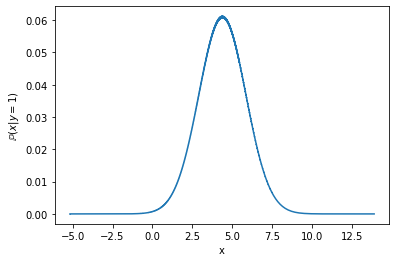

In [181]:
# Now, let us see how to generate a conditional distribution from samples;
# we shall do just one, since the procedure would be exactly identical for more.

yc, zc = samples_gibbs.conditional_kde(index=0, other_parameter=1)
# We condition on y=1, finding the same distribution shown in the first figure of the notebook

# Here we use a Kernel Density Estimate of the full distribution
# (again, computed with KDEpy)
# which we then slice on the desired value.
plt.plot(yc, zc)
plt.xlabel('x')
plt.ylabel('$\\mathbb{P}(x | y = 1)$')

Text(0, 0.5, '$\\mathbb{P}(x | y = 1)$')

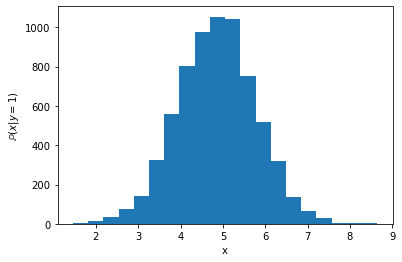

In [182]:
# The alternative, without the use of KDE, is to plot a simple histogram
# of the samples which fall in a narrow slice around the desired value

# Of course, this means there is a tradeoff between the accuracy of the distribution
# - going further from the desired value will warp its shape -
# and the sample size, since a narrower slice will have fewer points in it.

cs = samples_gibbs.conditional_cut(index=0, other_parameter=1, thr=.2)
_ = plt.hist(cs[:,0], bins=20)
plt.xlabel('x')
plt.ylabel('$\\mathbb{P}(x | y = 1)$')

In [180]:
# Let us summarize how the Credible Intervals given by the three sampling methods

print('Credible Intervals: (xmin, xmax), then (ymin, ymax); ')
print('differences from the true values.')

true_intervals = np.array([CI_x_analytical, CI_y_analytical])

with np.printoptions(precision=3):
    print('\nCholesky sampling')
    print(np.array(samples_ch.intervals(CL)) - true_intervals)
    print('\nGibbs sampling')
    print(np.array(samples_gibbs.intervals(CL)) -true_intervals)
    print('\nMetropolis-Hastings sampling')
    print(np.array(samples_mh.intervals(CL)) - true_intervals)

Credible Intervals: (xmin, xmax), then (ymin, ymax); 
differences from the true values.

Cholesky sampling
[[-0.022 -0.012]
 [ 0.012 -0.001]]

Gibbs sampling
[[ 0.013 -0.001]
 [ 0.02  -0.006]]

Metropolis-Hastings sampling
[[ 0.022  0.036]
 [-0.013 -0.033]]


In [168]:
# The next three cells can be uncommented to provide plots 
# of the scaling of the errors for the three kinds of sampling.

# These plots (possibly with slightly different parameters)
# are provided, precompiled, in the folder "figures"
# since they take a while to be made

In [169]:
# chain_length = 10

# g_1 = MultipleChains(Gibbs, n.pdf, initial_positions[:5], chain_length, conditional)

# trimming_index = 80
# N, e_mean, e_cov = errors_sampler(g_1, n, max_num=int(1e6), trimming_index=trimming_index)
# plot_errors(N, e_mean, e_cov, g_1, trimming_index=trimming_index)

In [170]:
# chain_length = 10

# mh_1 = MultipleChains(MetropolisHastings, n.pdf, initial_positions[:5], chain_length, gaussian_proposal)

# trimming_index = 80
# N, e_mean, e_cov = errors_sampler(mh_1, n, max_num=int(1e6), trimming_index=trimming_index)
# plot_errors(N, e_mean, e_cov, mh_1, trimming_index=trimming_index)

In [171]:
# chain_length = 10

# ch_1 = MultipleChains(Cholesky, n.pdf, initial_positions[:5], chain_length, n.cholesky_sample)

# trimming_index = 0
# N, e_mean, e_cov = errors_sampler(ch_1, n, max_num=int(1e6), trimming_index=trimming_index)
# plot_errors(N, e_mean, e_cov, ch_1, trimming_index=trimming_index)